<a href="https://colab.research.google.com/github/Shubham-Mate/Disaster-Tweet-Classification-with-BERT/blob/main/Disaster_Tweet_Prediction_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

ERROR: Operation cancelled by user


In [ ]:
!pip install contractions

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246768 sha256=a758ae978bafba24780251f38b36fdb7a6d5de3a32052a8d7359a94e7e03c375
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2024-08-11 10:54:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   166MB/s    in 29s     

2024-08-11 10:55:08 (150 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
!gunzip /content/cc.en.300.bin.gz

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ddsshubham","key":"dda10412908304f6fac2fd44aee10f79"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 118MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import tensorflow as tf
import zipfile
import re
import html
import contractions
import fasttext

In [ ]:
# Extract the zip file
with zipfile.ZipFile("nlp-getting-started.zip") as zip_ref:
  zip_ref.extractall()

In [ ]:
# define some constants
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
WORD_VEC_FILE = 'cc.en.300.bin'
BATCH_SIZE = 32
EPOCHS = 2

In [ ]:
df = pd.read_csv(TRAIN_FILE)
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [ ]:
# Our goal is to only predict whether it is a disaster tweet based on text, so we'll remove the keyword and location
df = df.drop(['keyword', 'location'], axis=1)
df.set_index('id', inplace=True) # Set the index to the id given in datafram
df.head()

text  target
id                                                           
1   Our Deeds are the Reason of this #earthquake M...       1
4              Forest fire near La Ronge Sask. Canada       1
5   All residents asked to 'shelter in place' are ...       1
6   13,000 people receive #wildfires evacuation or...       1
7   Just got sent this photo from Ruby #Alaska as ...       1

In [ ]:
def see_random_tweets(df, n=5):

  '''See Random Tweets along with their classification as disaster tweet or not'''

  n_random = np.array(df.sample(n))
  for i in range(n):
    #print(row)
    print(f'Tweet: {n_random[i][0]}')
    print(f'Classification: {n_random[i][1]}')

In [ ]:
see_random_tweets(df)

Tweet: ./.....hmm 12000 Nigerian refugees repatriated from Cameroon http://t.co/96p3hUJNTj /(
Classification: 1
Tweet: Suicide bomber kills 15 in Saudi security site mosque - A suicide bomber killed at least 15 people in an attack on... http://t.co/FY0r9o7Xsl
Classification: 1
Tweet: The MF Life is a vocal and lyrical bomb. Saw her live this summer. AMAZING vocalist. RT @THEmale_madonna: Melanie Fiona is so slept on ??
Classification: 0
Tweet: ? Cracker - White Riot ? http://t.co/Cc7D0wxk0M #nowplaying
Classification: 0
Tweet: Everyday is a near death fatality for me on the road. Thank god is on my side.??
Classification: 0


## List of Text Preprocessing tasks:
* Remove links
* Process @s
* Process hashtags
* Process capitalization
* Process Punctuation
* Convert HTML Escape Sequences to actual character


In [ ]:
def preprocess_text(text):
  '''
  Preprocess text
  * Converts HTML escape sequences (Eg: &gt;) to actual character (Eg: >)
  * Makes tweet lower case
  * Removes links
  * Removes @s
  * Replaces multiple instances of !, ? and . with single instance
  * Removes hashtags
  * Returns text and hashtags
  '''

  text = text.lower()

  url_regex = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
  twitter_at_regex = '@[\w]+'
  hashtag_regex = '#([\w]+)'


  text = html.unescape(text)
  text = re.sub(url_regex, '', text)
  text = re.sub(twitter_at_regex, '', text)
  text = re.sub("!+", '!', text)
  text = re.sub("\.+", '.', text)
  text = re.sub("\?+", '?', text)
  hashtags = re.findall(hashtag_regex, text)
  hashtags = '' if hashtags == None else ' '.join(hashtags)
  text = re.sub(hashtag_regex, '', text)
  text = contractions.fix(text)

  return [text, hashtags]

In [ ]:
df[['text', 'hashtags']] = df.apply(lambda row: preprocess_text(row.text), axis='columns', result_type='expand')
df.head()

text  target  \
id                                                              
1   our deeds are the reason of this  may allah fo...       1   
4              forest fire near la ronge sask. canada       1   
5   all residents asked to 'shelter in place' are ...       1   
6   13,000 people receive  evacuation orders in ca...       1   
7   just got sent this photo from ruby  as smoke f...       1   

            hashtags  
id                    
1         earthquake  
4                     
5                     
6          wildfires  
7   alaska wildfires

## Model

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
BERTmodel = transformers.TFAutoModel.from_pretrained('bert-base-uncased')
BERTmodel.trainable=False
BERTmodel.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(df[['hashtags', 'text']], df.target, test_size=0.2, random_state=42)

In [ ]:
trainX_tokenized = tokenizer(trainX.text.tolist(), max_length=128, padding='max_length', truncation=True)
testX_tokenized = tokenizer(testX.text.tolist(), max_length=128, padding='max_length', truncation=True)

trainX_tokenized

{'input_ids': [[101, 26103, 1998, 7481, 4106, 1997, 2342, 2000, 2224, 9593, 5968, 1999, 3386, 1012, 2887, 2510, 4188, 7806, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1059, 6392, 1038, 1037, 9467, 2065, 2008, 5439, 11122, 2150, 24692, 1999, 7311, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2425, 2000, 24501, 15459, 2094, 6665, 1997, 1005, 3932, 1005, 2445, 2000, 2149, 3548, 2012, 1996, 92

In [ ]:
fasttext_model = fasttext.load_model(WORD_VEC_FILE)

In [ ]:
def get_hashtag_wordvecs(hashtag_col):
  word_vec = np.zeros((hashtag_col.shape[0], 300))
  for i in range(hashtag_col.shape[0]):
    hashtag_split = hashtag_col.iloc[i].split()
    for word in hashtag_split:
      word_vec[i] += fasttext_model.get_word_vector(word)

    if (len(hashtag_split) > 0):
      word_vec[i] /= len(hashtag_split)

  return word_vec

In [ ]:
trainX.hashtags.shape

(6090,)

In [ ]:
train_hashtags = get_hashtag_wordvecs(trainX.hashtags)
test_hashtags = get_hashtag_wordvecs(testX.hashtags)

train_hashtags

array([[ 0.00569367,  0.01148738, -0.05958319, ...,  0.02124754,
        -0.00466958, -0.01166822],
       [ 0.00583919,  0.04946617,  0.01321725, ...,  0.01736508,
         0.01852176,  0.00720785],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
input_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
input_hashtags = tf.keras.layers.Input(shape=(300,), name='hashtag_input')

x = tf.keras.layers.Dense(64, activation='relu')(input_hashtags)
x = tf.keras.layers.Dense(16, activation='relu')(x)

features = BERTmodel([input_ids, input_mask]).last_hidden_state[:, 0, :]
features = tf.keras.layers.Concatenate(axis=1)([features, x])

out = tf.keras.layers.Dense(64, activation='relu')(features)
output = tf.keras.layers.Dense(1, activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask, input_hashtags], outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 hashtag_input (InputLayer)  [(None, 300)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',     

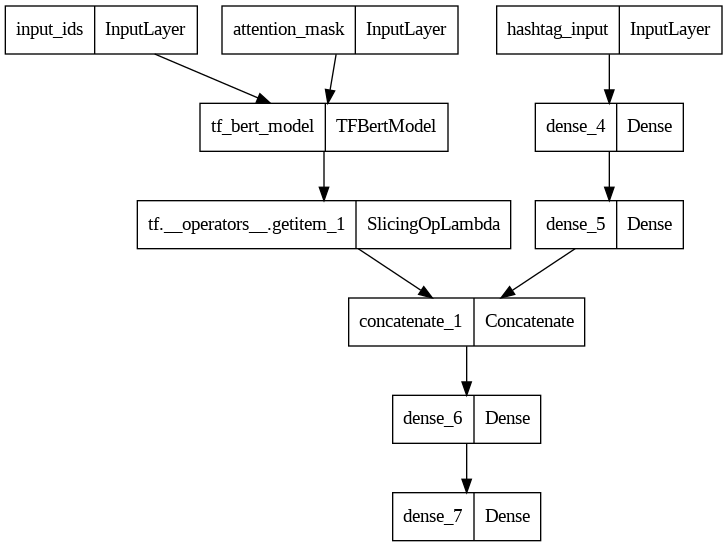

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 472
_oh 640
_dh 64
In 472
Out 640
get_ipython 64
exit 48
quit 48
_ 14616128
__ 48
___ 56
_i 774
_ii 477
_iii 413
_i1 69
_exit_code 24
_i2 74
_i3 84
_i4 70
_i5 125
_i6 69
_i7 74
_i8 83
_i9 82
_i10 83
_i11 82
_i12 94
files 72
_12 232
_i13 128
_i14 99
_i15 258
np 72
pd 72
plt 72
sns 72
transformers 72
tf 72
zipfile 72
re 72
html 72
contractions 72
fasttext 72
_i16 154
zip_ref 48
_i17 195
TRAIN_FILE 58
TEST_FILE 57
WORD_VEC_FILE 62
BATCH_SIZE 28
EPOCHS 28
_i18 87
df 1701835
_18 1222
_i19 298
_19 774
_i20 323
see_random_tweets 144
_i21 70
_i22 1084
preprocess_text 144
_i23 171
_23 1056
_i24 244
tokenizer 48
BERTmodel 48
_i25 201
train_test_split 144
trainX 1442412
testX 330671
trainY 97456
testY 24384
_i26 266
trainX_tokenized 48
testX_tokenized 48
_26 48
_i27 179
_i28 100
fasttext_model 48
_i29 314
get_hashtag_wordvecs 144
_i30 218
_i31 276
_31 48
_i32 184
train_hashtags 14616128
test_hashta

In [ ]:
train_encodings = {key: np.array(val) for key, val in trainX_tokenized.items()}
train_labels = np.array(trainY)

test_encodings = {key: np.array(val) for key, val in testX_tokenized.items()}
test_labels = np.array(testY)

In [ ]:
len(trainX_tokenized['input_ids'][0])

128

In [ ]:
train_encodings['input_ids'].shape

(6090, 128)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([train_encodings['input_ids'], train_encodings['attention_mask'], train_hashtags],
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask'], test_hashtags], test_labels))

Epoch 1/2
191/191 [==============================] - 85s 373ms/step - loss: 0.4979 - accuracy: 0.7645 - val_loss: 0.4754 - val_accuracy: 0.7787
Epoch 2/2
191/191 [==============================] - 79s 412ms/step - loss: 0.4569 - accuracy: 0.7928 - val_loss: 0.4414 - val_accuracy: 0.8102


## Final Results:
* Training Accuracy: 79.28%
* Test Accuracy: 81.02%